# Test the model on cloud

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This lets us make predictions (or inferences) from the model. Note that we don't have to host using the same type of instance that we used to train. Training is a prolonged and compute heavy job with different compute and memory requirements that hosting typically does not. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment takes several minutes, and can be accomplished with a single line of code calling the `deploy` method.

Note that some use cases require large sets of inferences on a predefined body of images.  In those cases, you do not need to make the inferences in real time.  Instead, you could use SageMaker's [batch transform jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html).

## Step 1: Creating EndPoint

<span style="color:red">Please copy the model name from previous session</span>.

In [1]:
model_name='object-detection-2020-11-26-07-27-10-908-mod'

In [3]:
import boto3
from time import gmtime, strftime


sm = boto3.client('sagemaker')
endpoint_config_name = "object-detection-ep-config" + strftime("-%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = "object-detection-ep" + strftime("-%Y-%m-%d-%H-%M-%S", gmtime())

print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])


# create sagemaker endpoint
create_endpoint_api_response = sm.create_endpoint(
EndpointName=endpoint_name,
EndpointConfigName=endpoint_config_name,
)

print ("create_endpoint API response", create_endpoint_api_response)            


object-detection-ep-config-2020-11-26-08-02-22
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:966911974471:endpoint-config/object-detection-ep-config-2020-11-26-08-02-22
create_endpoint API response {'EndpointArn': 'arn:aws:sagemaker:us-east-1:966911974471:endpoint/object-detection-ep-2020-11-26-08-02-22', 'ResponseMetadata': {'RequestId': 'f3f7e245-5364-4d7f-b9ad-638d033f0842', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f3f7e245-5364-4d7f-b9ad-638d033f0842', 'content-type': 'application/x-amz-json-1.1', 'content-length': '107', 'date': 'Thu, 26 Nov 2020 08:02:22 GMT'}, 'RetryAttempts': 0}}


## Step 2:  Test the model

<span style="color:red">Please make sure the endpoint is ready before executing</span>.

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference.  The results of a call to the inference endpoint are in a format that is similar to the .lst format, with the addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't visualize low-confidence predictions.

We have provided a script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [9]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img = mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width  = img.shape[1]
        colors = dict()
        num_detections = 0
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            num_detections += 1
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id], linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            print('{},{}'.format(class_name,score))
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        print('Number of detections: ' + str(num_detections))
        plt.show()

Now we use our endpoint to try to detect objects within an image. Since the image is a jpeg, we use the appropriate content_type to run the prediction. The endpoint returns a JSON object that we can simply load and peek into. We have packaged the prediction code into a function to make it easier to test other images.  Note that we are defaulting the confidence threshold to 30% in our example, as a couple of the birds in our sample images were not being detected as clearly.  Defining an appropriate threshold is entirely dependent on your use case.

In [10]:
#OBJECT_CATEGORIES = classes_df['class_id'].values.tolist()
OBJECT_CATEGORIES = ['bird']
import boto3
import json

runtime = boto3.client(service_name='runtime.sagemaker')

def show_bird_prediction(filename, ep, thresh=0.7):
    b = ''
    with open(filename, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep,
                                           ContentType='image/jpeg',
                                           Body=b)
    results = endpoint_response['Body'].read()
    detections = json.loads(results)
    visualize_detection(filename, detections['prediction'], OBJECT_CATEGORIES, thresh)

birds/104.jpg
bird,0.7329011559486389
Number of detections: 1


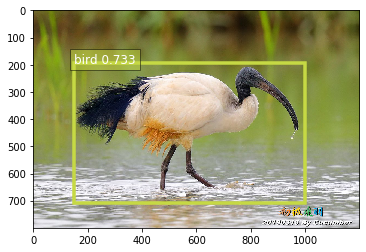

birds/1540362976-812679874_n.jpg
bird,0.7203477025032043
Number of detections: 1


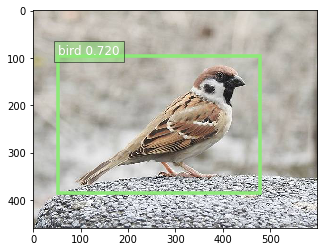

birds/b103.jpg
bird,0.884726881980896
Number of detections: 1


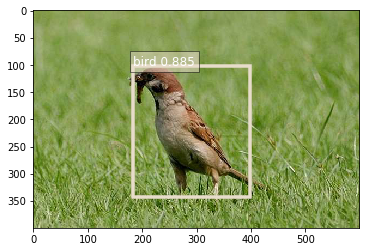

birds/b101.jpeg
bird,0.9475197196006775
Number of detections: 1


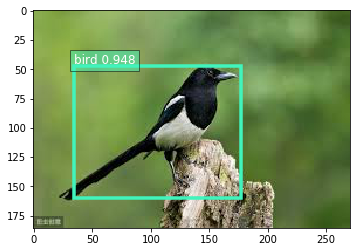

birds/103.jpg
bird,0.7573082447052002
bird,0.6043979525566101
Number of detections: 2


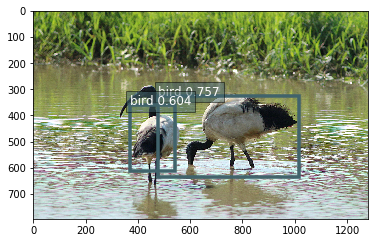

birds/105.jpg
bird,0.8029382228851318
Number of detections: 1


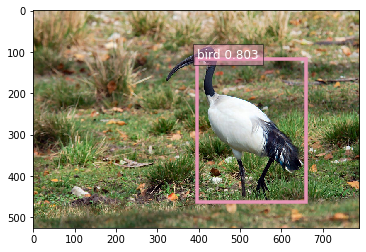

In [13]:
import os
def test_birds(ep):
    for filename in os.listdir('birds'):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"): 
            pic=os.path.join('birds', filename)
            print(pic)
            show_bird_prediction(pic, ep,0.5)
    
    


#test_birds(object_detector.endpoint_name)
test_birds(endpoint_name)



## Step 3: Final cleanup
Here we delete the SageMaker endpoint, as we will no longer be performing any inferences.  This is an important step, as your account is billed for the amount of time an endpoint is running, even when it is idle.

In [14]:
# delete the new endpoint
import sagemaker
sagemaker.Session().delete_endpoint(endpoint_name)